In [1]:
import os
from functools import partial
from pathlib import Path
from tqdm import tqdm
from scipy.integrate import odeint

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow as tf
import tensorflow_probability as tfp

import bayesflow as bf
from bayesflow.benchmarks.sir import configurator, prior, simulator

from tensorflow.keras.utils import to_categorical
from tensorflow_probability import distributions as tfd
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D

from sc_abi.sc_amortizers import AmortizedPosteriorLikelihoodSC
from sc_abi.sc_simulation import PriorLogProb
from sc_abi.sc_schedules import ZeroOneSchedule, ZeroLinearOneSchedule

2024-03-28 05:54:30.929159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/zizi/mambaforge/envs/sc_sbi/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
CHECKPOINT_DIR = Path("checkpoints_sir")
# create if it does not exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

X_DIM = 160
SIM_BUDGET = 2048

In [3]:
# Comment out, if you want scientific notation
np.set_printoptions(suppress=True)

# Comment out, if you want tensorflow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [4]:
# Prior: set the prior as normal and exp the theta in the simulator
# working with the prior logspace causes NAN loss as we end up sampling
# close to 0 but negative values, which causes issues.
sir_prior = PriorLogProb(
    dist=tfp.distributions.Independent(
        tfp.distributions.Normal(
            [np.log(0.4).astype(np.float32), np.log(1 / 8).astype(np.float32)],
            [0.5, 0.2],
        ),
        reinterpreted_batch_ndims=1,
    )
)


# Likelihood
def _deriv(x, t, N, beta, gamma):
    """Helper function for scipy.integrate.odeint."""

    S, I, R = x
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I
    dR = gamma * I
    return dS, dI, dR


def simulator(
    theta,
    N=1e6,
    T=160,
    I0=1.0,
    R0=0.0,
    subsample=10,
    total_count=1000,
    scale_by_total=True,
    rng=None,
):
    """
    rewrite prior
    """

    # Use default RNG, if None specified
    if rng is None:
        rng = np.random.default_rng()

    # Create vector (list) of initial conditions
    x0 = N - I0 - R0, I0, R0

    # Unpack parameter vector into scalars
    beta, gamma = np.exp(theta)  # theta is normal, so exp

    # Prepate time vector between 0 and T of length T
    t_vec = np.linspace(0, T, T)

    # Integrate using scipy and retain only infected (2-nd dimension)
    irt = odeint(_deriv, x0, t_vec, args=(N, beta, gamma))[:, 1]

    # Subsample evenly the specified number of points, if specified
    if subsample is not None:
        irt = irt[:: (T // subsample)]

    # Truncate irt, so that small underflow below zero becomes zero
    irt = np.maximum(irt, 0.0)

    # Add noise and scale, if indicated
    x = rng.binomial(n=total_count, p=irt / N)
    if scale_by_total:
        x = x / total_count
    return x


sir_simulator = partial(simulator, subsample=X_DIM)

# Combine in a model
generative_model = bf.simulation.GenerativeModel(
    prior=sir_prior,
    simulator=sir_simulator,
    prior_is_batched=True,
    simulator_is_batched=False,
)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 160)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [5]:
# sanity check data format etc.
np.random.seed(420)
tf.random.set_seed(420)

theta = sir_prior()
outcome = sir_simulator(theta)
# simulate data
sim_data = generative_model(batch_size=10)
print(sim_data["sim_data"].shape)  # [B, x-dim=160]
assert sim_data["sim_data"].shape == (10, X_DIM)

(10, 160)


In [6]:
# Setup netwowrks ####
# summary net for posterior
def get_summary_network():
    return bf.networks.DeepSet(summary_dim=4)


# latent distribution
def get_latent_dist_lik(solution_points: int = X_DIM):
    return tfp.distributions.MultivariateStudentTLinearOperator(
        df=30,
        loc=[0.0] * solution_points,
        scale=tf.linalg.LinearOperatorDiag([1.0] * solution_points),
    )


def get_latent_dist_post():
    return tfp.distributions.MultivariateStudentTLinearOperator(
        df=30,
        loc=[0.0] * 2,
        scale=tf.linalg.LinearOperatorDiag([1.0] * 2),
    )


def get_amortized_posterior():
    return bf.amortizers.AmortizedPosterior(
        bf.networks.InvertibleNetwork(
            num_params=2,
            num_coupling_layers=5,
            coupling_design="interleaved",
            permutation="learnable",
        ),
        # summary_net=get_summary_network(),
        latent_dist=get_latent_dist_post(),
    )


def get_amortized_likelihood(solution_points: int = X_DIM):
    return bf.amortizers.AmortizedLikelihood(
        bf.networks.InvertibleNetwork(
            num_params=solution_points,
            num_coupling_layers=5,
            coupling_design="interleaved",
            permutation="learnable",
        ),
        latent_dist=get_latent_dist_lik(solution_points),
    )


def get_amortizer_arguments(solution_points: int = X_DIM):
    return {
        "amortized_posterior": get_amortized_posterior(),
        "amortized_likelihood": get_amortized_likelihood(solution_points),
    }

In [7]:
trainer_baseline = bf.trainers.Trainer(
    amortizer=bf.amortizers.AmortizedPosteriorLikelihood(**get_amortizer_arguments()),
    generative_model=generative_model,
    default_lr=1e-3,
    memory=False,
    checkpoint_path=CHECKPOINT_DIR / f"npe{SIM_BUDGET}",
    configurator=bf.benchmarks.Benchmark("sir", "joint").configurator,
    max_to_keep=1,
)

INFO:root:Performing 2 pilot runs with the sir model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from checkpoints_sir/npe2048/history_100.pkl.
INFO:root:Networks loaded from checkpoints_sir/npe2048/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [8]:
# TRAINING DATA
tf.random.set_seed(1)
np.random.seed(1)

sir_train = generative_model(batch_size=SIM_BUDGET)
sir_val = generative_model(batch_size=256)

In [9]:
# h = trainer_baseline.train_offline(
#     sir_train, epochs=100, batch_size=32, validation_sims=sir_val
# )

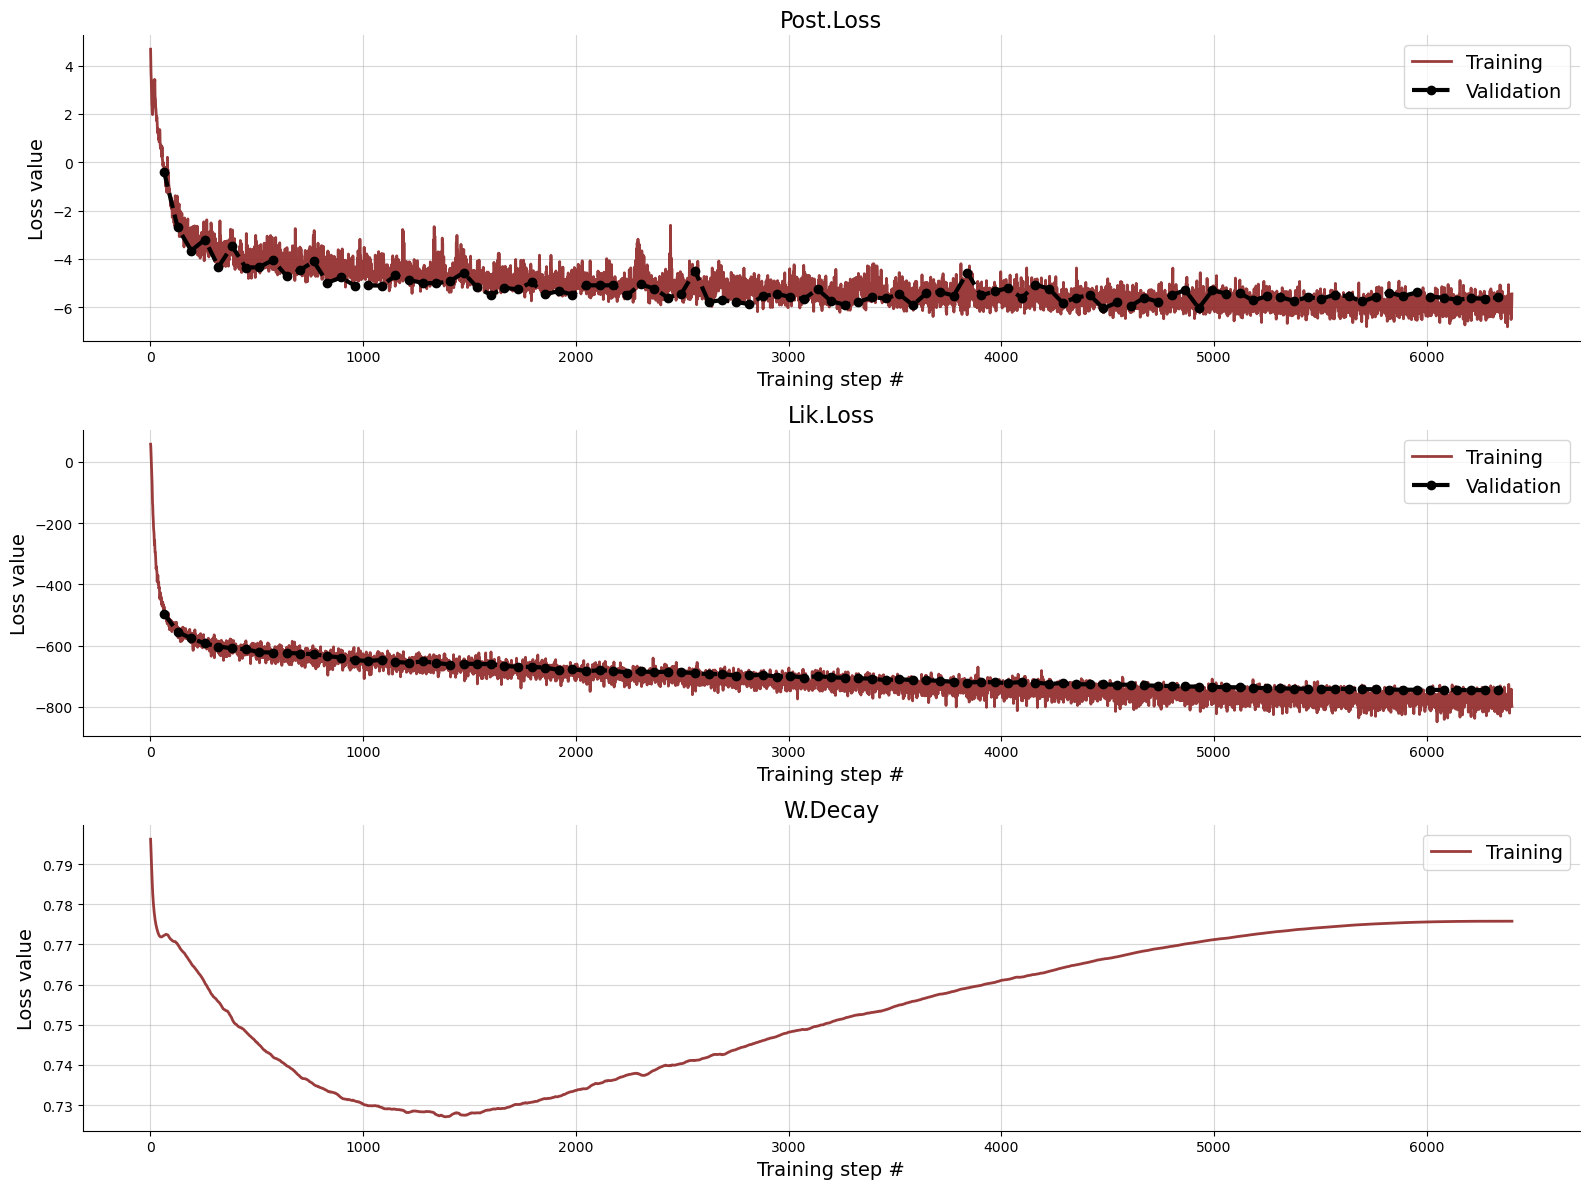

In [10]:
h = trainer_baseline.loss_history.get_plottable()
f = bf.diagnostics.plot_losses(h["train_losses"], h["val_losses"])

In [11]:
## With SC
sc_samples = 100
sc_lambda = 0.1

trainer_sc = bf.trainers.Trainer(
    amortizer=AmortizedPosteriorLikelihoodSC(
        **get_amortizer_arguments(),
        prior=sir_prior,  # !!
        n_consistency_samples=sc_samples,
        lambda_schedule=(
            ZeroOneSchedule(threshold_step=100)
            if sc_lambda == 1.0
            else ZeroLinearOneSchedule(  # type: ignore
                # this is basically a step (ZeroOneSchedule)
                threshold1=120,
                threshold2=130,
                lmd=sc_lambda,
            )
        ),
        theta_clip_value_min=-2.0,
        theta_clip_value_max=2.0,
    ),
    generative_model=generative_model,
    default_lr=1e-3,
    memory=False,
    checkpoint_path=CHECKPOINT_DIR / f"sc{SIM_BUDGET}_l{sc_lambda}_s{sc_samples}",
    configurator=bf.benchmarks.Benchmark("sir", "joint").configurator,
    max_to_keep=1,
)

INFO:root:Performing 2 pilot runs with the sir model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from checkpoints_sir/sc2048_l0.1_s100/history_100.pkl.
INFO:root:Networks loaded from checkpoints_sir/sc2048_l0.1_s100/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [12]:
# h_sc = trainer_sc.train_offline(
#     sir_train, epochs=100, batch_size=32, validation_sims=sir_val
# )

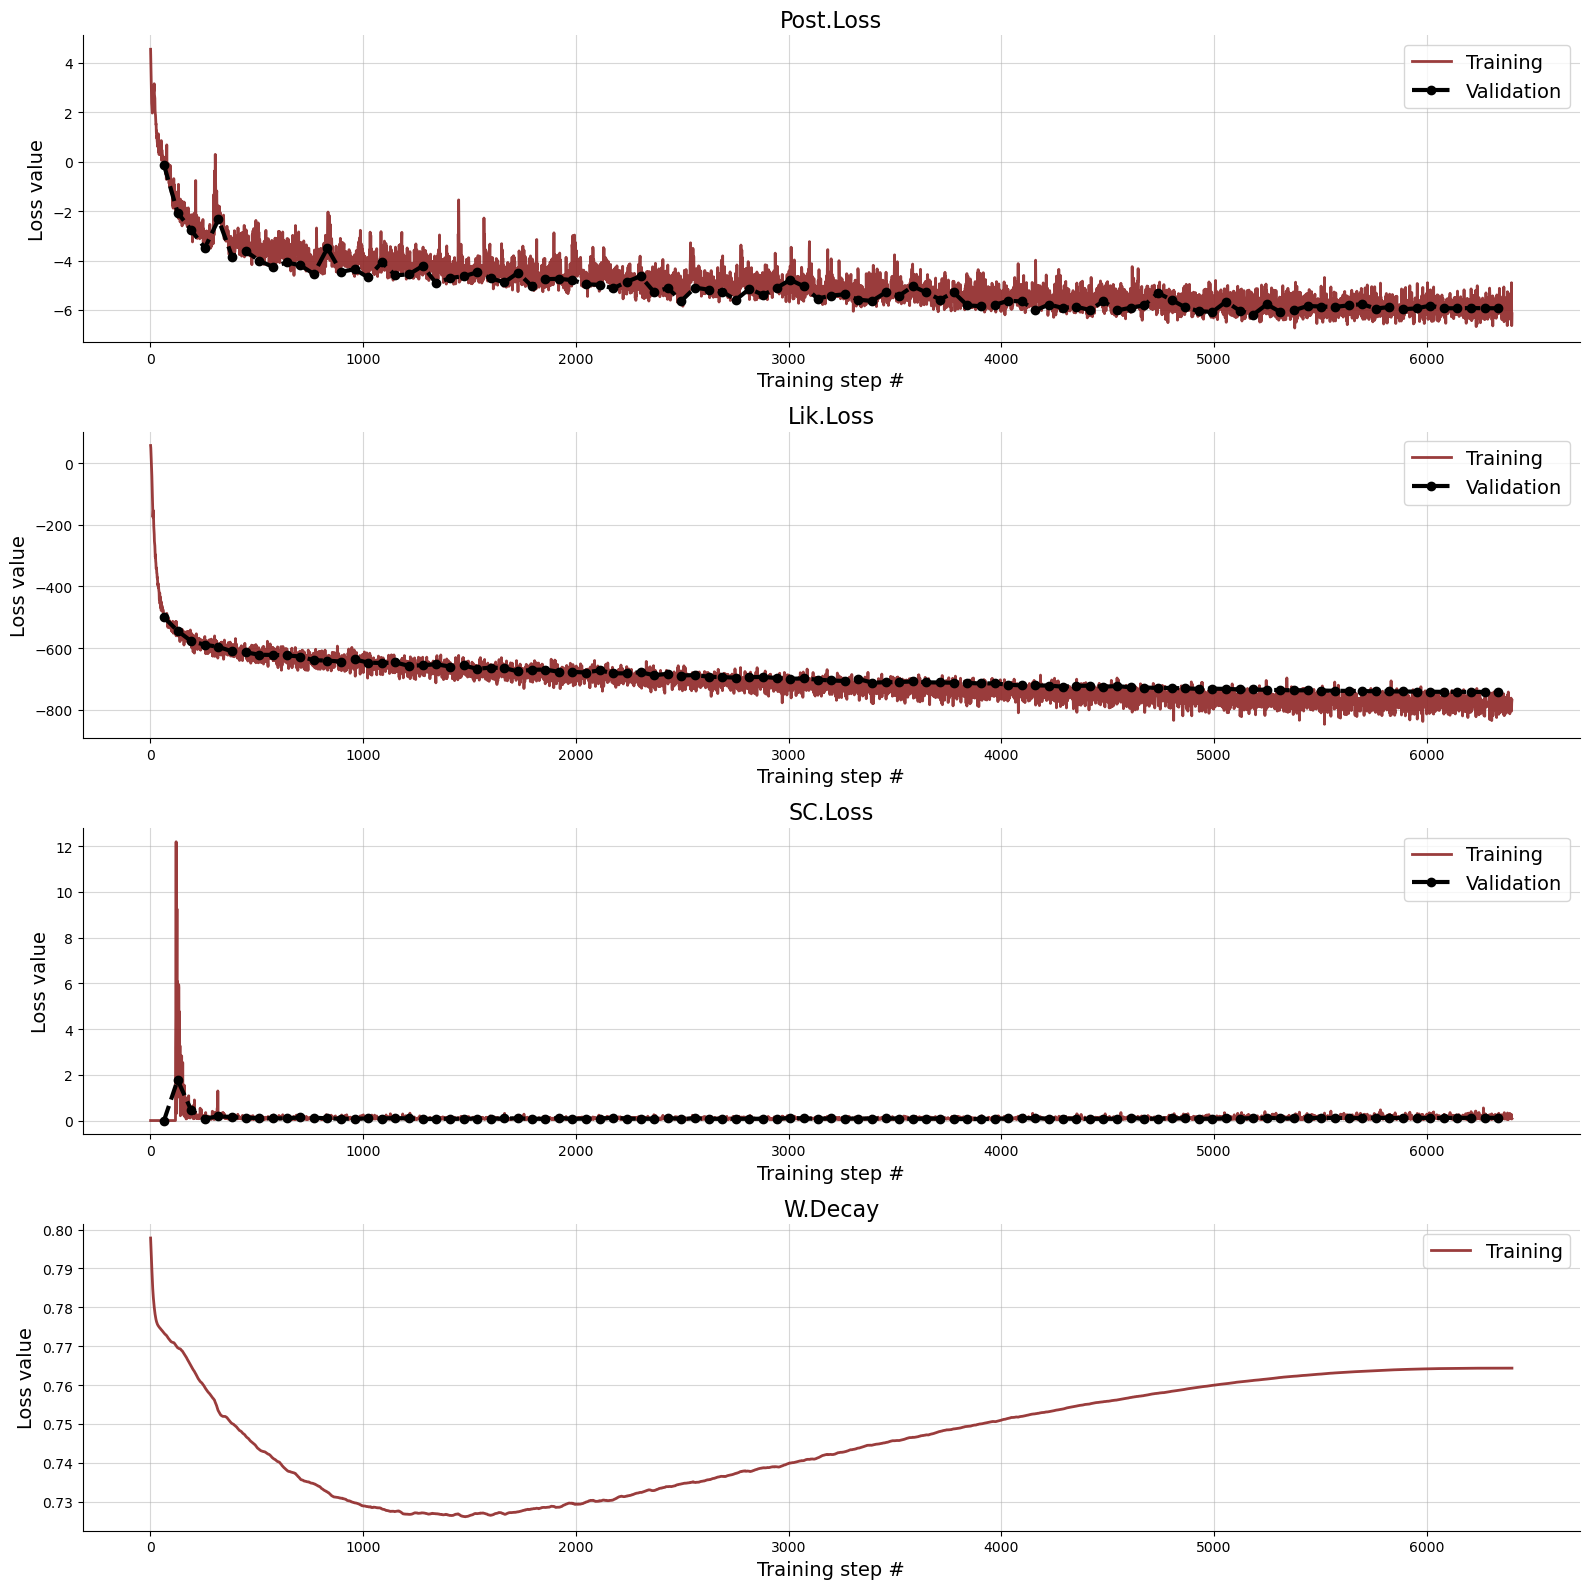

In [13]:
h_sc = trainer_sc.loss_history.get_plottable()
f_sc = bf.diagnostics.plot_losses(h_sc["train_losses"], h_sc["val_losses"])

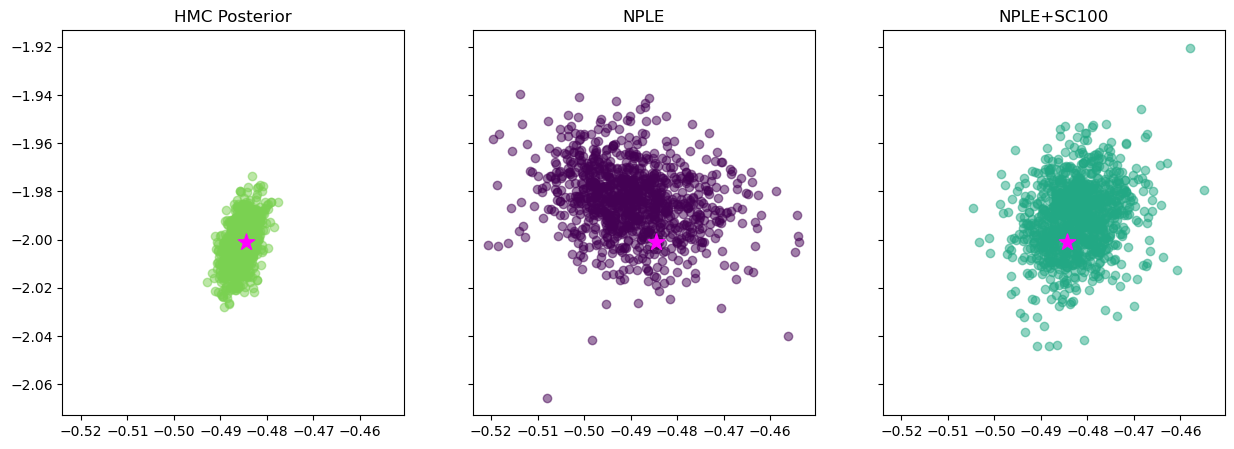

In [37]:
# open posterior_samples_sir.pkl
i = 2
cmap = plt.get_cmap("viridis", 6)

with open("posterior_samples_sir.pkl", "rb") as f:
    data = pickle.load(f)
    posterior_samples = data["posterior_samples"]
    x = data["x"]
    fwd_thetas = data["theta_true"]
    test_sims = data["eval_sims_for_amortizers"]

# fwd_eval = posterior_samples[""]
# fwd_theta = fwd_eval["prior_draws"]
# test_sims = trainer_baseline.configurator(fwd_eval)
fwd_theta = fwd_thetas[[i]]
hmc_post = posterior_samples[i]
# sample from NPE
npe_samples = trainer_baseline.amortizer.sample(test_sims, 1000, 0)[
    "posterior_samples"
][i]
# sample from SC
sc_samples = trainer_sc.amortizer.sample(test_sims, 1000, 0)["posterior_samples"][i]
# sample from the prior
prior_samples = sir_prior(1000)

# plot
f, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
# plot samples from the HMC posterior
ax[0].scatter(
    hmc_post[:, 0],
    hmc_post[:, 1],
    alpha=0.5,
    color=cmap(4),
)
ax[0].set_title("HMC Posterior")
ax[0].scatter(fwd_theta[0, 0], fwd_theta[0, 1], color="magenta", s=150, marker="*")

# plot samples from the NPE
ax[1].scatter(npe_samples[:, 0], npe_samples[:, 1], alpha=0.5, color=cmap(0))
ax[1].set_title("NPLE")
# add the true theta which is in fwd_eval["prior_draws"]
ax[1].scatter(fwd_theta[0, 0], fwd_theta[0, 1], color="magenta", s=150, marker="*")

ax[2].scatter(sc_samples[:, 0], sc_samples[:, 1], alpha=0.5, color=cmap(3))
ax[2].set_title("NPLE+SC100")
ax[2].scatter(fwd_theta[0, 0], fwd_theta[0, 1], color="magenta", s=150, marker="*")
plt.show()

In [38]:
# save the plot to pdf
f.savefig("sir_posterior_samples.pdf")

# Evaluate vs HMC